# Convoluted Pneumonia Detection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime

np.random.seed(42)
tf.random.set_seed(42)

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

2025-02-07 01:24:14.650156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 01:24:14.660833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738909454.673636   69104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738909454.677193   69104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 01:24:14.691060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Notebook last run (end-to-end): 2025-02-07 01:24:15.833084


In [2]:
test_dir = "../data/test"
train_dir = "../data/train"
validation_dir = "../data/val"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

height, width, channels = 150, 150, 3

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=20,
    class_mode='binary',
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=20,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=20,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# print class labels
print(f"Class labels: {train_generator.class_indices}")

Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


Normal images in test set: 234
Pneumonia images in test set: 390


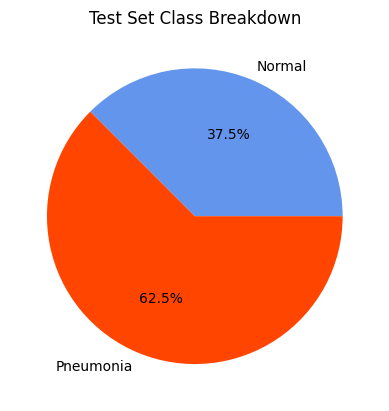

In [4]:
# compare number of images in each category
test_normal_images_count = len(test_generator.classes[test_generator.classes == 0])
test_pneumonia_images_count = len(test_generator.classes[test_generator.classes == 1])

print(f"Normal images in test set: {test_normal_images_count}")
print(f"Pneumonia images in test set: {test_pneumonia_images_count}")

fig, ax = plt.subplots()
ax.pie([test_normal_images_count, test_pneumonia_images_count],
       labels=[f'Normal', f'Pneumonia'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
plt.title('Test Set Class Breakdown')
plt.show()

Normal images in train set: 1341
Pneumonia images in train set: 3875


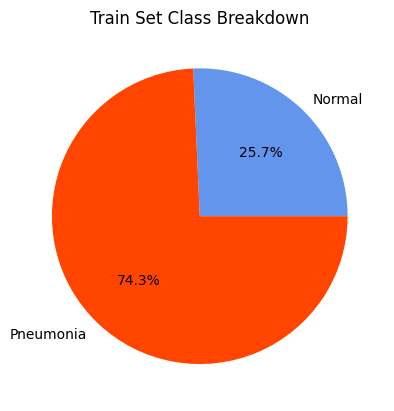

In [5]:
train_normal_images_count = len(train_generator.classes[train_generator.classes == 0])
train_pneumonia_images_count = len(train_generator.classes[train_generator.classes == 1])

print(f"Normal images in train set: {train_normal_images_count}")
print(f"Pneumonia images in train set: {train_pneumonia_images_count}")

# pie chart of the distribution of images
fig, ax = plt.subplots()
ax.pie([train_normal_images_count, train_pneumonia_images_count],
       labels=[f'Normal', f'Pneumonia'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
plt.title('Train Set Class Breakdown')
plt.show()

There's a clear skew towards pneumonia images, so we can't rely on accuracy: just classifying all images as pneumonia would give over 60% test accuracy! We'll refer to the confusion matrix to see true positives, true negatives, false positives, and false negatives, and draw conclusions from there. 

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Convolutional Neural Nets

In [7]:
batch_size = 20
epochs = 15

steps_per_epoch = len(train_generator)//batch_size
validation_steps = len(validation_generator)//batch_size

In [8]:
# Using CNN configuration from tensorflow tutorial: https://www.tensorflow.org/tutorials/images/cnn
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)
model_1.loss, model_1.accuracy = model_1.evaluate(test_generator)

2025-02-07 01:24:16.077230: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/sam/Documents/projects/ConvolutedPneumoniaDetection/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.7980 - loss: 0.6018 - val_accuracy: 0.5000 - val_loss: 0.8081
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7855 - loss: 0.5253 - val_accuracy: 0.5000 - val_loss: 0.9500
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.7229 - loss: 0.5654 - val_accuracy: 0.5000 - val_loss: 0.8239
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.8044 - loss: 0.3669 - val_accuracy: 0.6250 - val_loss: 0.8300
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.8756 - loss: 0.2749 - val_accuracy: 0.6250 - val_loss: 1.0790
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.8896 - loss: 0.2877 - val_accuracy: 0.6250 - val_loss: 0.6707
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.8765 - loss: 0.2887 - val_accuracy: 0.6250 - val_loss: 1.3421
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.8884 - loss: 0.2638 - val_accuracy: 0.

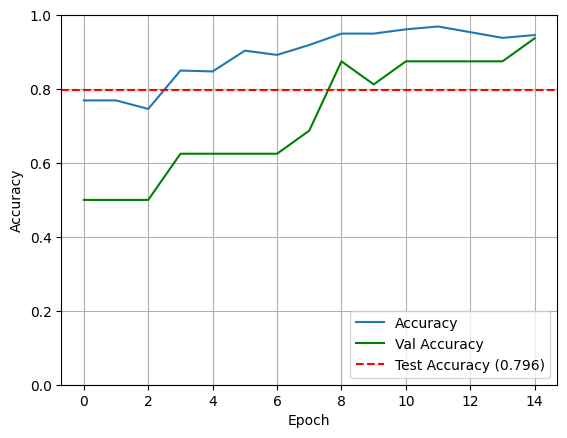

In [9]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy', color='g')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.axhline(model_1.accuracy, color='r', linestyle='--', label=f"Test Accuracy ({model_1.accuracy:.3f})")
plt.legend(loc='lower right')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


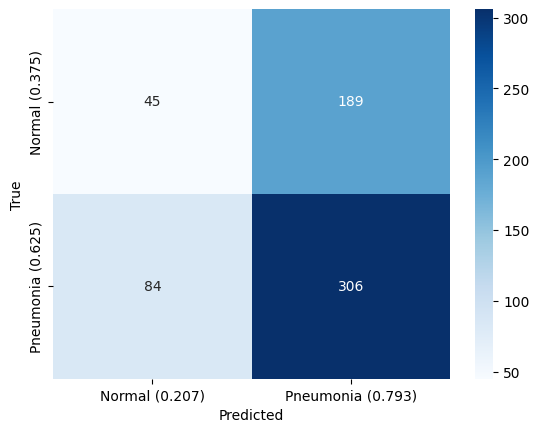

              precision    recall  f1-score   support

           0       0.35      0.19      0.25       234
           1       0.62      0.78      0.69       390

    accuracy                           0.56       624
   macro avg       0.48      0.49      0.47       624
weighted avg       0.52      0.56      0.53       624



In [10]:
y_pred = model_1.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes

ax = plt.subplot()
cm = confusion_matrix(y_true, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
ax.yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])

plt.show()
print(classification_report(y_true, y_pred))

In [11]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)
model_2.loss, model_2.accuracy = model_2.evaluate(test_generator)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.7650 - loss: 0.5992 - val_accuracy: 0.5000 - val_loss: 0.7453
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.6941 - loss: 0.6310 - val_accuracy: 0.5000 - val_loss: 0.8666
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7726 - loss: 0.5524 - val_accuracy: 0.5000 - val_loss: 0.7477
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7595 - loss: 0.5314 - val_accuracy: 0.6250 - val_loss: 0.6748
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7629 - loss: 0.4830 - val_accuracy: 0.6250 - val_loss: 0.7827
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8592 - loss: 0.3508 - val_accuracy: 0.5000 - val_loss: 0.7577
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9288 - loss: 0.1916 - val_accuracy: 0.8125 - val_loss: 0.5795
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9380 - loss: 0.1519 - val_accuracy: 0.

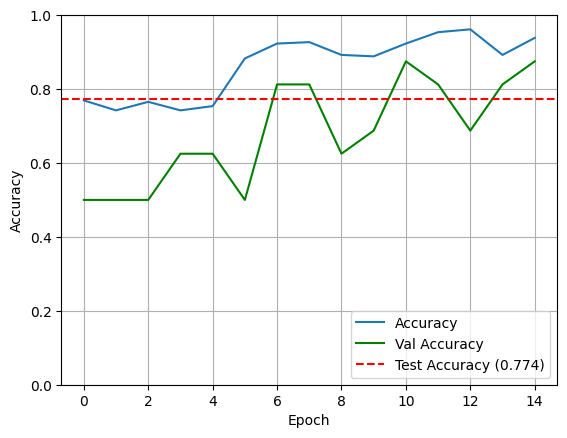

In [12]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy', color='g')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.axhline(model_2.accuracy, color='r', linestyle='--', label=f"Test Accuracy ({model_2.accuracy:.3f})")
plt.legend(loc='lower right')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


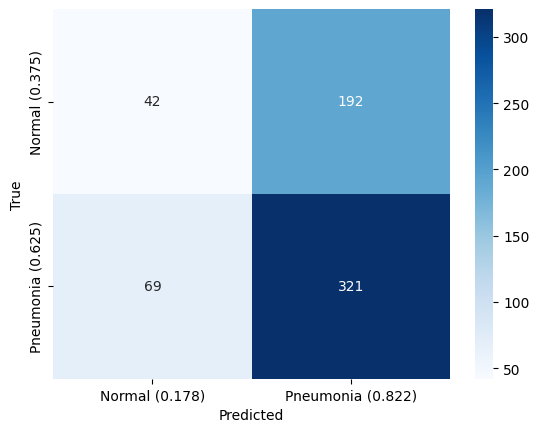

              precision    recall  f1-score   support

           0       0.38      0.18      0.24       234
           1       0.63      0.82      0.71       390

    accuracy                           0.58       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.53      0.58      0.54       624



In [13]:
y_pred = model_2.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes

ax = plt.subplot()
cm = confusion_matrix(y_true, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
ax.yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])

plt.show()
print(classification_report(y_true, y_pred))

Although it looks like our accuracy went up, our precision and recall both went down!

In [14]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_3.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)
model_3.loss, model_3.accuracy = model_3.evaluate(test_generator)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.6259 - loss: 0.6505 - val_accuracy: 0.5000 - val_loss: 1.0480
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.6978 - loss: 0.6654 - val_accuracy: 0.5000 - val_loss: 0.7183
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.7860 - loss: 0.4151 - val_accuracy: 0.6250 - val_loss: 1.4692
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - accuracy: 0.8710 - loss: 0.3483 - val_accuracy: 0.6250 - val_loss: 0.7850
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.9179 - loss: 0.2570 - val_accuracy: 0.7500 - val_loss: 0.4337
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.9081 - loss: 0.2570 - val_accuracy: 0.8125 - val_loss: 0.4551
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.9198 - loss: 0.1696 - val_accuracy: 0.8125 - val_loss: 0.5069
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.9581 - loss: 0.1336 - val_accuracy: 0.

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


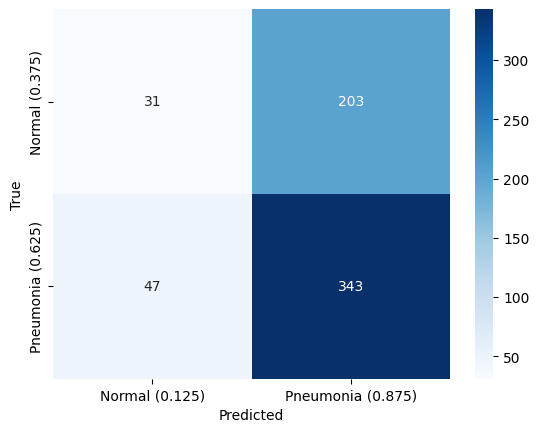

              precision    recall  f1-score   support

           0       0.40      0.13      0.20       234
           1       0.63      0.88      0.73       390

    accuracy                           0.60       624
   macro avg       0.51      0.51      0.47       624
weighted avg       0.54      0.60      0.53       624



In [15]:
y_pred = model_3.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes

ax = plt.subplot()
cm = confusion_matrix(y_true, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
ax.yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])

plt.show()
print(classification_report(y_true, y_pred))

In [16]:
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_4.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)
model_4.loss, model_4.accuracy = model_4.evaluate(test_generator)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.6441 - loss: 0.6286 - val_accuracy: 0.5000 - val_loss: 0.7811
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.7525 - loss: 0.5130 - val_accuracy: 0.5625 - val_loss: 0.7703
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9087 - loss: 0.3359 - val_accuracy: 0.5000 - val_loss: 1.5894
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.8718 - loss: 0.2794 - val_accuracy: 0.6250 - val_loss: 0.6458
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.8869 - loss: 0.2571 - val_accuracy: 0.7500 - val_loss: 0.4970
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.9236 - loss: 0.1923 - val_accuracy: 0.7500 - val_loss: 0.5476
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9759 - loss: 0.1094 - val_accuracy: 0.6875 - val_loss: 0.9722
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.9489 - loss: 0.1930 - val_accuracy: 0.

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


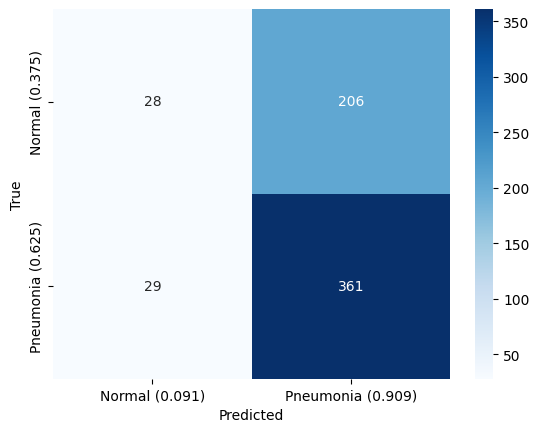

              precision    recall  f1-score   support

           0       0.49      0.12      0.19       234
           1       0.64      0.93      0.75       390

    accuracy                           0.62       624
   macro avg       0.56      0.52      0.47       624
weighted avg       0.58      0.62      0.54       624



In [17]:
y_pred = model_4.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes

ax = plt.subplot()
cm = confusion_matrix(y_true, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
ax.yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])

plt.show()
print(classification_report(y_true, y_pred))

In [18]:
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_5.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)
model_5.loss, model_5.accuracy = model_5.evaluate(test_generator)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.6279 - loss: 0.6681 - val_accuracy: 0.5625 - val_loss: 0.6755
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.7874 - loss: 0.5815 - val_accuracy: 0.5000 - val_loss: 0.6798
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.7455 - loss: 0.4998 - val_accuracy: 0.6250 - val_loss: 1.2472
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.8475 - loss: 0.3361 - val_accuracy: 0.5000 - val_loss: 0.9288
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.9061 - loss: 0.2688 - val_accuracy: 0.8125 - val_loss: 0.4575
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step - accuracy: 0.9096 - loss: 0.2075 - val_accuracy: 0.8125 - val_loss: 0.4687
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.9323 - loss: 0.1611 - val_accuracy: 0.6875 - val_loss: 0.5881
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.9081 - loss: 0.2151 - val_accuracy: 0.

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step


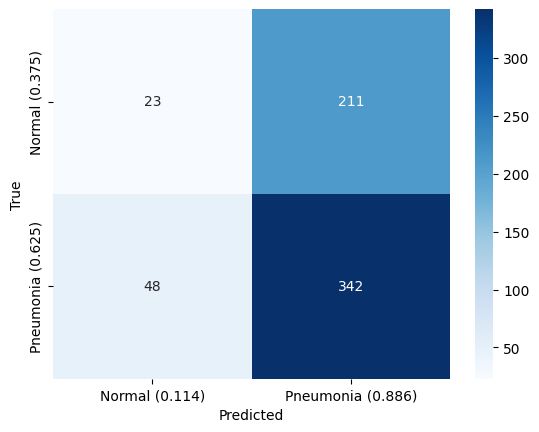

              precision    recall  f1-score   support

           0       0.32      0.10      0.15       234
           1       0.62      0.88      0.73       390

    accuracy                           0.58       624
   macro avg       0.47      0.49      0.44       624
weighted avg       0.51      0.58      0.51       624



In [19]:
y_pred = model_5.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes

ax = plt.subplot()
cm = confusion_matrix(y_true, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

ax.xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
ax.yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])

plt.show()
print(classification_report(y_true, y_pred))

Our precision and recall for the pneumonia category is great, but the normal category looks terrible across all our models! There are fewer samples in the normal category, so we need some way to prevent the neural net from ignoring them.

## Conclusion

In [20]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-02-07 01:29:24.714793 (duration: 0:05:08.881709)
